# Config

In [1]:
import os
import glob
import cv2
from math import *
import numpy as np
import collections

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from skimage.feature import hog

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from scipy.ndimage.measurements import label
from sklearn.pipeline import Pipeline

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
%load_ext autoreload
%autoreload 2

carsPath = '../_data/vehicles/*/*.png'
noncarsPath = '../_data/non-vehicles/*/*.png'

randomState = 123

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# Dataset

CPU times: user 130 ms, sys: 10 ms, total: 140 ms
Wall time: 1.2 s


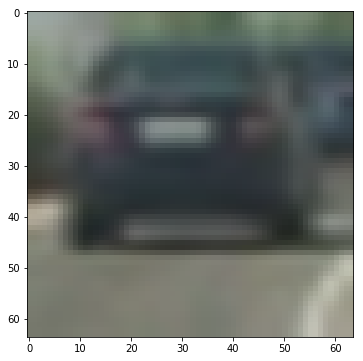

In [2]:
%%time

cars = glob.glob(carsPath)
notcars = glob.glob(noncarsPath)

# Preview
testCarImagePath = "../_data/vehicles/GTI_Far/image0001.png"
testCarImage = mpimg.imread(testCarImagePath)
plt.figure(figsize = (8,6))
plt.imshow(testCarImage, cmap="gray")

# Feature extraction

CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 99 ms


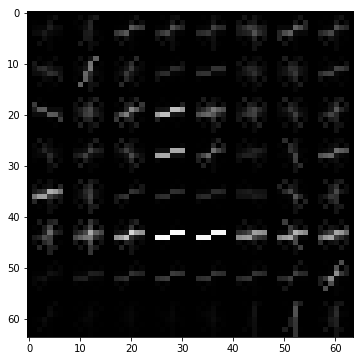

In [3]:
%%time

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):

    hog_image = None
    features = None
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)

    else:
        # Otherwise call with one output
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        
    return features, hog_image

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []

    fileCount = 0
    # Iterate through the list of images
    for file in imgs:
        
        fileCount = fileCount + 1
        
        if fileCount % 1000 == 0:
            print(fileCount)
                            
        # Read in each one by one
        image = mpimg.imread(file)

        image = (image*255).astype(np.uint8)

        file_features, _ = extract_features_image(image, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat, vis=False)
            
        features.append(file_features)
        
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def extract_features_image(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):

    #1) Define an empty list to receive features
    img_features = []
    preview_image = None

    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                features, preview_image = get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=vis, feature_vec=True)
                hog_features.append()
            hog_features = np.ravel(hog_features)
        else:
            hog_features, preview_image = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=vis, feature_vec=True)

        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features), preview_image

# Preview
_, testImageHog = extract_features_image(testCarImage, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
plt.figure(figsize = (8,6))
plt.imshow(testImageHog, cmap="gray")

In [4]:
%%time

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

1000
2000
3000
4000
5000
6000
7000
8000
1000
2000
3000
4000
5000
6000
7000
8000
CPU times: user 56.8 s, sys: 5.97 s, total: 1min 2s
Wall time: 2min


# Train classifier

In [5]:
%%time

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomState)

clf = Pipeline([('scaling', StandardScaler()),
                ('classification', LinearSVC(loss='hinge')),
               ])

# Train
clf.fit(X_train, y_train)

# Print accuracy
print('Accuracy: ', round(clf.score(X_test, y_test), 4))

Accuracy:  0.9834
CPU times: user 6.3 s, sys: 1.96 s, total: 8.26 s
Wall time: 9.3 s


# Drawing

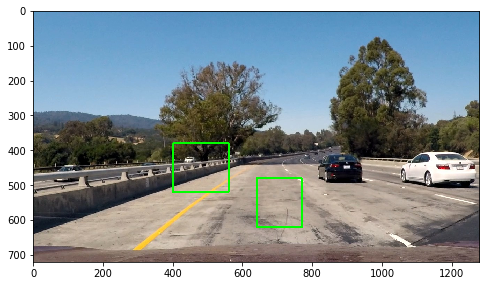

In [6]:
def draw_bboxes(image, candidates):
    for window in candidates:
        cv2.rectangle(image, (window[0][0], window[0][1]), (window[1][0], window[1][1]), (0,255,0), 3)
    return image

# Preview
testSceneImage = mpimg.imread('test_images/test1.jpg')
windows = [((400, 380),  (560, 520)), ((640, 480),  (770, 620))]
testSceneImageWithTestWindows = draw_bboxes(np.copy(testSceneImage), windows)
plt.figure(figsize = (8,6))
plt.imshow(testSceneImageWithTestWindows, cmap='gray')

# Sliding window

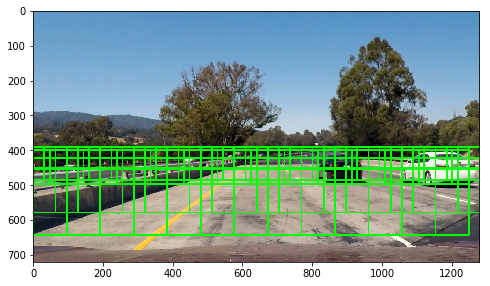

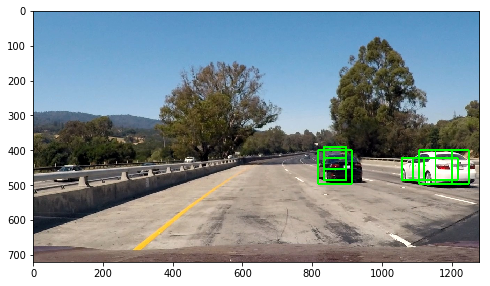

In [7]:
# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img_shape, x_start_stop=[None, None], y_start_stop=None,
                    xy_window=None, xy_overlap=(0.5, 0.5)):
    if xy_window is None:
        xy_window = (32, 32)
    if y_start_stop is None:
        y_start_stop = [None, None]
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img_shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img_shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def create_windows(image_size):
    output = []
    
    pyramid = [((64, 64),  [390, 500]),
           ((96, 96),  [400, 500]),
           ((128, 128),[450, 578]),
           ((192, 192),[450, None])
      ]
    
    for w_size, y_lims in pyramid:
        windows = slide_window(image_size, x_start_stop=[None, None], y_start_stop=y_lims, xy_window=w_size, xy_overlap=(0.5, 0.5))
        output.extend(windows)
    return output

# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, color_space='RGB',
                    spatial_size=None, hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    all_features = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        
        # Size check
        if test_img.shape[1] > 0 and test_img.shape[0] > 0:
            test_img = cv2.resize(test_img, (64, 64))
            #4) Extract features for that window using extract_features_image()
            features, _ = extract_features_image(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
            #5) Scale extracted features to be fed to classifier
            test_features = np.array(features).reshape(1, -1)

            #6) Predict using your classifier
            prediction = clf.predict(test_features)

            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                on_windows.append(window)
                
    #8) Return windows for positive detections
    return on_windows

# Preview
windows = create_windows(testSceneImage.shape)
testSceneImageWithAllWindows = draw_bboxes(np.copy(testSceneImage), windows)
plt.figure(figsize = (8,6))
plt.imshow(testSceneImageWithAllWindows, cmap='gray')

testSceneImageWindows = search_windows(testSceneImage, windows, clf, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
testSceneImageWithCarWindows = draw_bboxes(np.copy(testSceneImage), testSceneImageWindows)
plt.figure(figsize = (8,6))
plt.imshow(testSceneImageWithCarWindows, cmap='gray')

# Heatmap

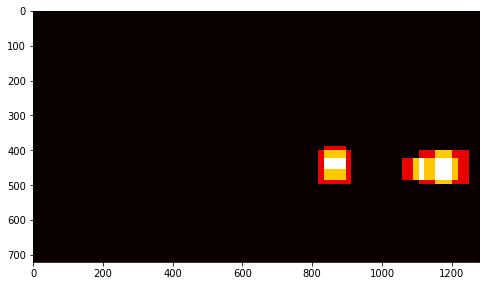

In [8]:
def get_heatmap(candidates, image_shape):
    
    heatmap = np.zeros((image_shape[0], image_shape[1]), np.uint8)

    for pt1, pt2 in candidates:
        x1, y1 = pt1
        x2, y2 = pt2
        x1 = min(max(x1, 0), image_shape[1])
        x2 = min(max(x2, 0), image_shape[1])
        y1 = min(max(y1, 0), image_shape[0])
        y2 = min(max(y2, 0), image_shape[0])
        xv, yv = np.meshgrid(range(x1, x2), range(y1, y2))

        heatmap[yv, xv] += 1

    return heatmap

# Preview
testSceneImageHeatmap = get_heatmap(testSceneImageWindows, testSceneImage.shape)
plt.figure(figsize = (8,6))
plt.imshow(testSceneImageHeatmap, cmap='hot')

# Bounding box

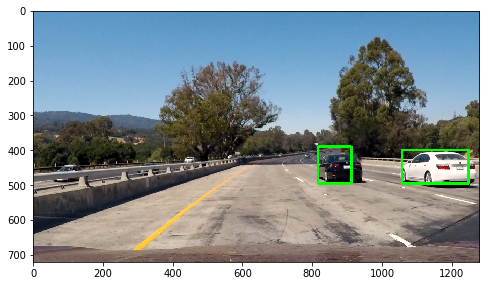

In [9]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

# Preview
testSceneImageLabel = label(testSceneImageHeatmap)
testSceneImageBoxes = draw_labeled_bboxes(np.copy(testSceneImage), testSceneImageLabel)
plt.figure(figsize = (8,6))
plt.imshow(testSceneImageBoxes, cmap='gray')

# Output images

In [32]:
# Generate output_images

def save_output_image(image, name, shouldConvert = True):
    if shouldConvert:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite("output_images/"+name+".jpg", image)

save_output_image(testImageHog*3000, "01_Test_hog", shouldConvert = False)
save_output_image(testSceneImage, "02_Test_image")
save_output_image(testSceneImageWithTestWindows, "03_Test_windows")
save_output_image(testSceneImageWithAllWindows, "04_All_windows")
save_output_image(testSceneImageWithCarWindows, "05_Car_windows_all")
save_output_image(testSceneImageHeatmap*200, "06_Heatmap", shouldConvert = False)
save_output_image(testSceneImageBoxes, "07_Car_windows")

# Pipeline

In [12]:
def process_image(image, params):
    
    # Variables
    config, clf, windows = params['clf_config'], params['clf'], params['windows']
    color_space = config['color_space']
    spatial_size = config['spatial_size']
    hist_bins = config['hist_bins']
    orient = config['orient']
    pix_per_cell = config['pix_per_cell']
    cell_per_block = config['cell_per_block']
    hog_channel = config['hog_channel']
    spatial_feat = config['spatial_feat']
    hist_feat = config['hist_feat']
    hog_feat = config['hog_feat']
    
    # Windows with cars
    windows = search_windows(image, windows, clf, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    # Heatmap
    current_heatmap = get_heatmap(windows, image.shape)
    
    # Heatmap history
    if params['cache_enabled']:
        cache = process_image.cache
        if cache['heatmaps'] is None:
            cache['heatmaps'] = collections.deque(maxlen=params['heatmap_cache_length'])
    if params['cache_enabled'] == True:
        cache['heatmaps'].append(current_heatmap)
        current_heatmap = sum(cache['heatmaps'])
    
    # Heatmap threshold
    current_heatmap[current_heatmap < params['heatmap_threshold']] = 0
    
    # Draw boxes
    labels = label(current_heatmap)
    image_boxes = draw_labeled_bboxes(np.copy(image), labels)
        
    return image_boxes, current_heatmap

# Test images

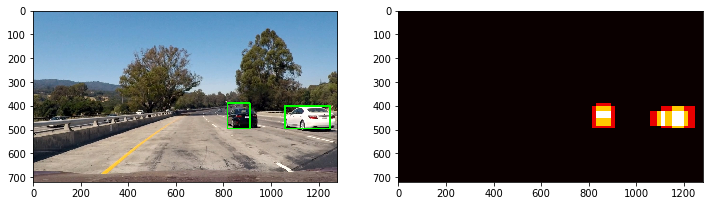

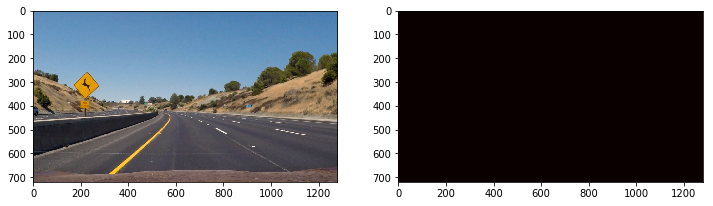

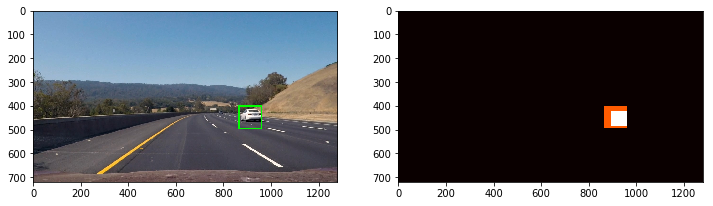

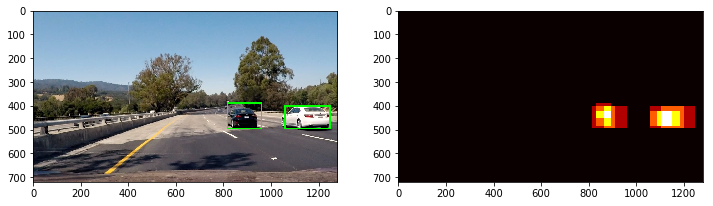

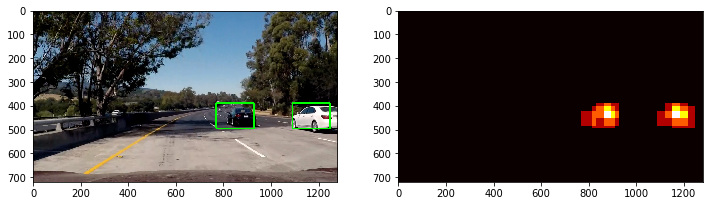

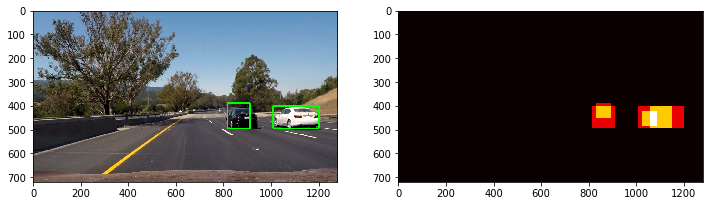

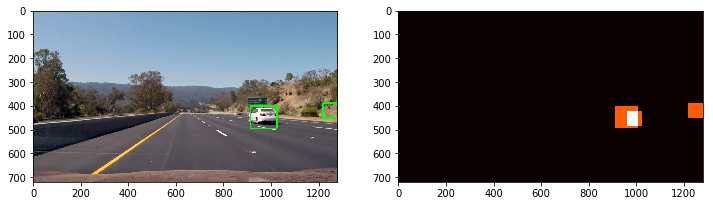

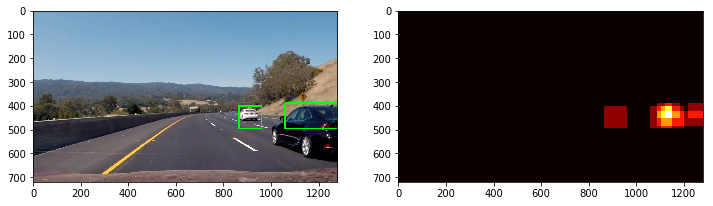

In [25]:
# Test image

process_image.cache = {}

config = dict(color_space=color_space, 
            spatial_size=spatial_size, hist_bins=hist_bins, 
            orient=orient, pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, 
            hog_channel=hog_channel, spatial_feat=spatial_feat, 
            hist_feat=hist_feat, hog_feat=hog_feat)

params = {}
params['clf'] = clf
params['clf_config'] = config
params['windows'] = windows
params['cache_enabled'] = False
params['heatmap_cache_length'] = 0
params['heatmap_threshold'] = 1

testImagesPath = "test_images/"
for filename in os.listdir(testImagesPath):
    filePath = os.path.join(testImagesPath, filename)
    
    try:
        image = mpimg.imread(filePath)
    except IOError:
        image = None
        
    if image != None:
        image, heatmap = process_image(image, params)
        plt.figure(figsize = (12, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.subplot(1, 2, 2)
        plt.imshow(heatmap, 'hot')

# Video

In [14]:
# Video

process_image.cache = {}

params = {}
params['clf_config'] = config
params['clf'] = clf
params['windows'] = windows
params['cache_enabled'] = True
params['heatmap_cache_length'] = 20
params['heatmap_threshold'] = 10

vid_output = 'project_video_output.mp4'
clip = VideoFileClip('project_video.mp4')

def process_frame(image, params):
    image, heatmap = process_image(image, params)
    return image

vid_clip = clip.fl_image(lambda x: process_frame(x, params))
vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [08:23<00:00,  2.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))